In [8]:
import pandas as pd
import seaborn as sns
import pingouin as pg
import scipy.stats as st
import numpy as np

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Функция для формирования цены по чеку
def price_maker(row):
    sum = 0
    for i in row:
        sum += prices[int(i)]
    return sum

In [11]:
users_data = pd.read_csv('ab_users_data.csv')
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv') 

# Метрики
1) Успешность продаж = неотмененные заказы / все заказы
2) Насыщаемость корзины - среднее количество разных продуктов в корзине. Предполагаю, что при умной рекомендации оно должна увеличиться.
3) Средний чек за заказ
4) Средний чек по дням
5) Возвращаемость - количество отдельных удачно завершенных заказов


In [12]:
users_data

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


## Подготовим данные

In [13]:
products = products.set_index('product_id')
prices = products['price'].to_dict()

In [14]:
full_data = users_data.merge(orders[['order_id', 'product_ids']], on = 'order_id', how = 'left')
full_data.time = pd.to_datetime(full_data.time)
full_data.date = pd.to_datetime(full_data.date)

In [15]:
full_data.product_ids = full_data.product_ids.str.strip('{}') \
                                             .str.replace(',', '') \
                                             .str.split(' ') 

In [16]:
full_data['order_price'] = full_data.product_ids.apply(lambda x: price_maker(x))
full_data['product_quantity'] = full_data.product_ids.apply(lambda x: len(x))

In [17]:
a_group = full_data.query("group == 0")
b_group = full_data.query("group == 1")

## Начнём с успешности продаж.
H0 -  распределение успешности продаж не зависит от вида системы рекомендации

In [18]:
sale_succes = pd.DataFrame()

In [19]:
sale_succes['a'] = a_group.action.value_counts()
sale_succes['b'] = b_group.action.value_counts()

In [20]:
sale_succes

,a,b
action,,
create_order,1609,2514
cancel_order,82,132


In [21]:
for_bar = pd.DataFrame()
for_bar['create_order'] = sale_succes.T.create_order / (sale_succes.T.create_order + sale_succes.T.cancel_order) * 100
for_bar['cancel_order'] = sale_succes.T.cancel_order / (sale_succes.T.create_order + sale_succes.T.cancel_order) * 100

In [22]:
for_bar

,create_order,cancel_order
a,95.150798,4.849202
b,95.011338,4.988662


<Axes: >

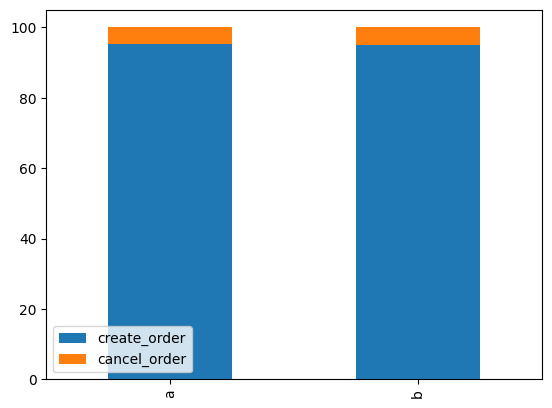

In [23]:
for_bar.plot(kind='bar', stacked=True)

In [24]:
chi, p, x, y = st.chi2_contingency(sale_succes)
p

0.8926523935841298

__Итог__: p> 0.05, отклонить нулевую гипотезу не можем

Действительно, система рекомендаций __не влияет__ на отмены

## Дальше насыщаемость корзины  
H0 : среднее в выборках А и В отличаются

<Axes: xlabel='product_quantity', ylabel='Count'>

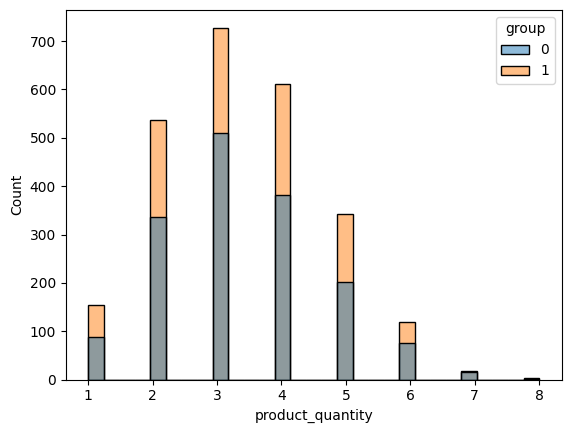

In [25]:
sns.histplot(data = full_data.query("action == 'create_order'"), x = 'product_quantity', hue = 'group')

In [26]:
a_group.query("action == 'create_order'").product_quantity.mean()

3.3499067743940336

In [27]:
b_group.query("action == 'create_order'").product_quantity.mean()

3.3556085918854417

__Итог__: без теста видно, что статитически значимых отличий нет

Теперь убираю из данных отмененные заказы. Не убирал их до этого, потому что считаю, что в момент формирования корзины ещё нет никакой значимости, отменит потом покупатель заказ или нет.

## И исследую средние чеки

In [28]:
cancel_orders = list(full_data.query("action != 'create_order'").order_id.values)

In [38]:
full_data_succes = full_data.query(f"order_id not in {cancel_orders}")
full_data_succes['order_price_lg'] = full_data_succes.order_price.apply(lambda x: np.log(x + 1))

In [32]:
succes_a = full_data.query("group == 0")
succes_b = full_data.query("group == 1")

In [33]:
succes_a.order_price.mean()

380.55688941454764

In [34]:
succes_b.order_price.mean()

370.308238851096

<Axes: xlabel='order_price', ylabel='Count'>

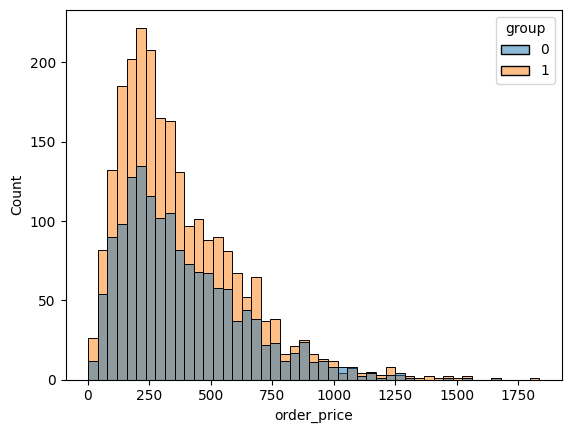

In [35]:
sns.histplot(data = full_data_succes, x = 'order_price', hue = 'group')

<Axes: xlabel='order_price_lg', ylabel='Count'>

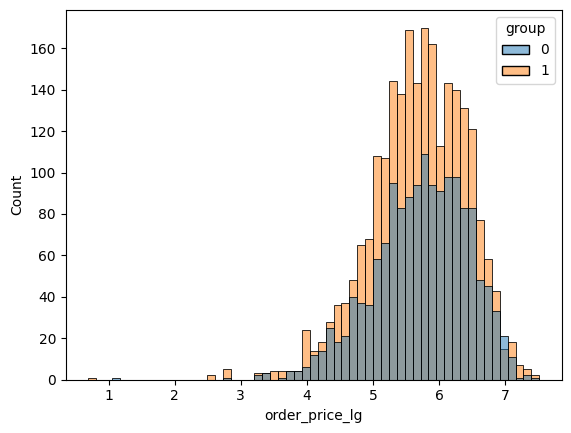

In [36]:
sns.histplot(data = full_data_succes, x = 'order_price_lg', hue = 'group')

Логарифмирование снова не сработало, хотя может и можно смотря на ЦПТ провести по T-критерию, но все равно логарифмирования влияет на постановку гипотезы, поэтому лучше использую Колмагорова.

H0: Выборки А и B по сумме за заказ не различаются

In [42]:
st.kstest(succes_a.order_price, succes_b.order_price)

KstestResult(statistic=0.03643159083726795, pvalue=0.12533358682214127, statistic_location=299.7, statistic_sign=-1)

__Итог:__   
    p > 0.05, Мы не можем отклонить нулевую гипотезу в обоих случаях

## Дальше посмотрим разброс суммы чека по дням. 
Здесь смотреть статистику уже не вижу смысла, но чисто графически глянуть, почему бы и нет.

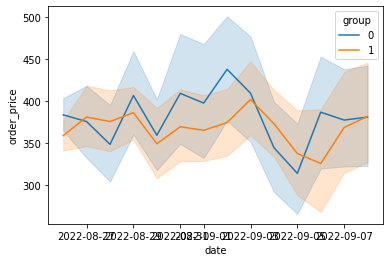

In [237]:
sns.lineplot(data = full_data_succes, x = 'date', y = 'order_price', hue = 'group')

## Последняя надежда человечества 
Может быть пользователю понравилась новая система, и в выборке B за данный нам участок времени он заказывает чаще, чем пользователь из выборки А?

Сравним распределения

По классике H0: Выборки А и B не различаются по возвращаемости

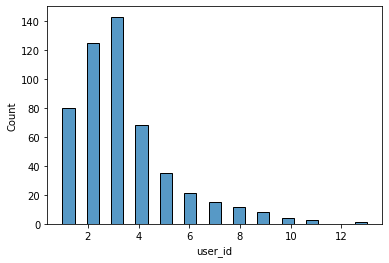

In [255]:
sns.histplot(succes_a.user_id.value_counts())

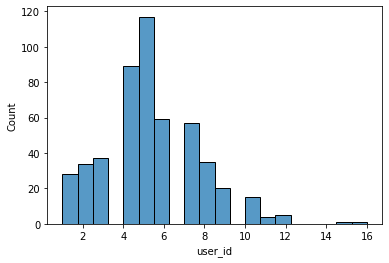

In [254]:
sns.histplot(succes_b.user_id.value_counts())

In [256]:
st.kstest(succes_b.user_id.value_counts(), succes_a.user_id.value_counts())

KstestResult(statistic=0.47851699996131974, pvalue=5.486899963041783e-54)

__Итог__: отклоняем нулевую гипотезу, ура.

Теперь попробуем __сравнить средние__, хоть и распределение ненормальное, но количество наблюдений как будто позволяет.

H0: Среднее выборок А и B по возвращаемости не различаются

In [257]:
succes_a.user_id.value_counts().mean()

3.283495145631068

In [258]:
succes_b.user_id.value_counts().mean()

5.270916334661354

In [260]:
pg.ttest(succes_b.user_id.value_counts(), succes_a.user_id.value_counts())

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.279076,980.593588,two-sided,3.645342e-42,"[1.71, 2.26]",0.897441,6.634e+38,1.0


__Итог__: отклоняем нулевую гипотезу
    
# Вывод
Несмотря на отсутвие изменений в характеристиках чека, пользователи из B-выборки делали заказы чаще, что позволяет нам говорить об увеличении прибыли. Катим новую версию на всех.